завантажимо і підготуємо дані, створимо модель, проведемо навчання та оцінку, а потім виведемо прогноз


# 1. Підготовка Даних



In [ ]:
%pip install tensorflow


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
import keras
from keras import layers, models

# завантажуємо історичні дані про акції
ticker = "AAPL"  # можна замінити на інший тикер
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

# використання лише стовпчика 'Close' для прогнозування
data = data[['Close']]

# масштабування даних, щоб нейронна мережа працювала стабільніше
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# визначення розміру вікна для створення тренувальних даних
window_size = 60
X_train, y_train = [], []

for i in range(window_size, len(scaled_data)):
    X_train.append(scaled_data[i - window_size:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# перетворення даних у тривимірний формат для LSTM: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


# 2. Створення та Налаштування Моделі ANN

Модель ANN для часових рядів найчастіше використовує LSTM шари, які добре працюють для прогнозування послідовностей

In [ ]:
# створення ANN моделі
model = keras.Sequential()

# 1й LSTM шар
model.add(keras.Input(shape=(window_size, 1)))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dense(units=25))  # Додатковий щільний шар

# 2й LSTM шар
model.add(layers.LSTM(units=50, return_sequences=False))
model.add(layers.Dense(units=25))

# вихідний шар
model.add(layers.Dense(units=1))

# компілюємо модель
model.compile(optimizer='adam', loss='mean_squared_error')


# 3. Навчання Моделі

Навчання моделі здійснюється на тренувальному наборі даних

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 0.0295
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 5.1166e-04
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 6.0313e-04
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 4.7886e-04
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 4.6576e-04
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 4.4328e-04
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.2945e-04
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.7534e-04
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 3.5048e-04
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 3.3427e-04


Примітка: Збільшення epochs може підвищити точність, але також призведе до більшого часу навчання

# 4. Тестування Моделі та Прогноз

протестуємо модель на нових даних і здійснимо прогноз

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


<ipython-input-28-fbbafb6251e4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


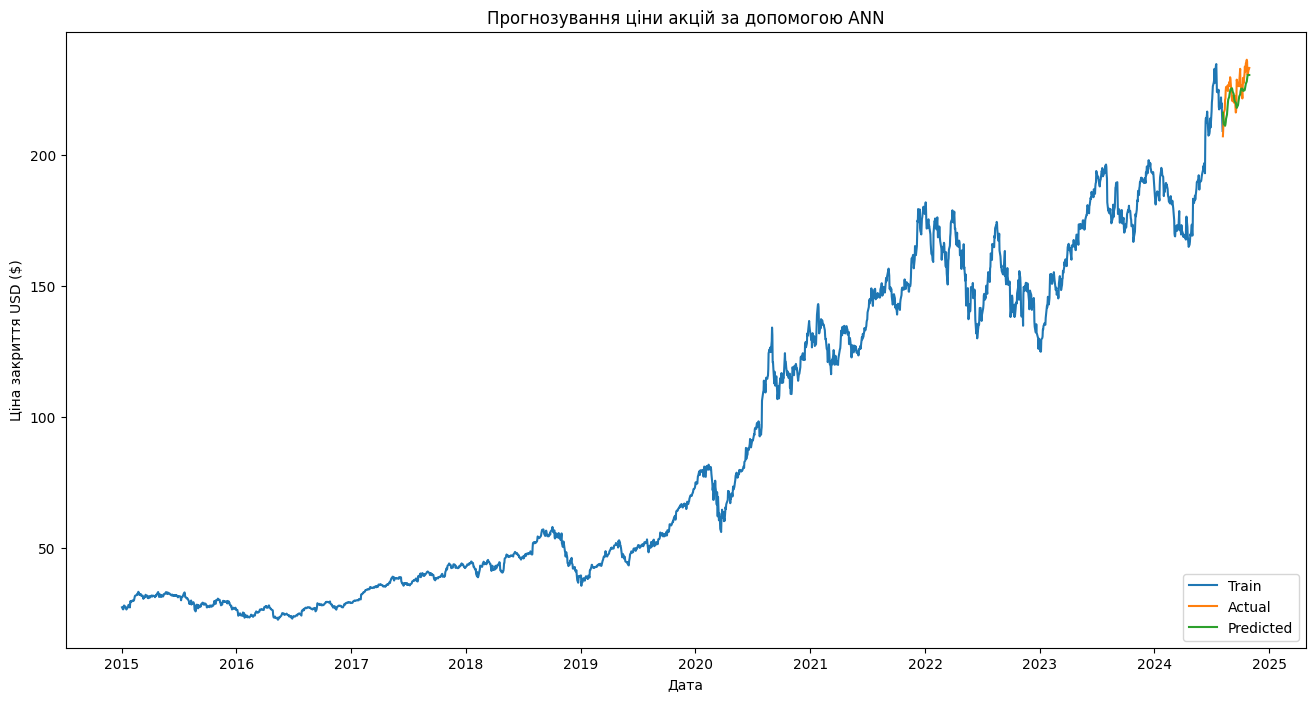

In [ ]:
# створення тестового набору даних
test_data = scaled_data[len(scaled_data) - window_size - 60:]
X_test = []
y_test = data['Close'][len(data) - 60:].values

# формування вхідних даних для тестування
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])

# перетворення даних для подачі на модель
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# прогнозуємо ціну
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Масштабуємо назад

# перевіряєм точність прогнозу
import matplotlib.pyplot as plt

train = data[:len(data)-60]
valid = data[len(data)-60:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Прогнозування ціни акцій за допомогою ANN')
plt.xlabel('Дата')
plt.ylabel('Ціна закриття USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()


# Опис Коду

Підготовка Даних: Імпортуємо історичні дані, масштабуємо їх і формуємо набори для навчання з вікном 60 днів.

Створення та Налаштування Моделі ANN: Використовуємо LSTM шари для обробки послідовностей, додаємо щільні (Dense) шари.

Навчання Моделі: Модель навчається на підготовлених даних.

Тестування Моделі та Прогноз: Прогнозуємо на тестових даних і виводимо графік для оцінки точності.

In [ ]:
# Налаштовуємо періоди для прогнозування в торгових днях
forecast_days = {
    "1_month": 20,
    "6_months": 120,
    # "1_year": 252,
    # "5_years": 1260
}

# Функція для прогнозування на заданий період
def multi_step_forecast(model, input_data, forecast_length, scaler):
    predictions = []
    input_sequence = input_data[-window_size:]  # Використовуємо останні точки даних для початкового вікна

    for _ in range(forecast_length):
        # Прогнозуємо наступний крок
        predicted = model.predict(np.reshape(input_sequence, (1, window_size, 1)))

        # Зберігаємо результат
        predictions.append(predicted[0, 0])

        # Оновлюємо вхідні дані: додаємо прогноз у вікно, видаляючи найстаріше значення
        input_sequence = np.append(input_sequence[1:], predicted, axis=0)

    # Зворотне масштабування прогнозованих значень
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Генеруємо прогнози на різні періоди
forecasts = {}
for period, days in forecast_days.items():
    forecasts[period] = multi_step_forecast(model, scaled_data, days, scaler)

# Виведемо прогнозовані значення для кожного періоду
for period, prediction in forecasts.items():
    print(f"Forecast for {period}: {prediction[-5:]}")  # Останні 5 прогнозів для кожного періоду


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━

multi_step_forecast: функція прогнозує ціну на потрібний період, використовуючи модель та масштабування.
for loop: для кожного періоду створюється графік, який показує історичні дані разом з прогнозом.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━

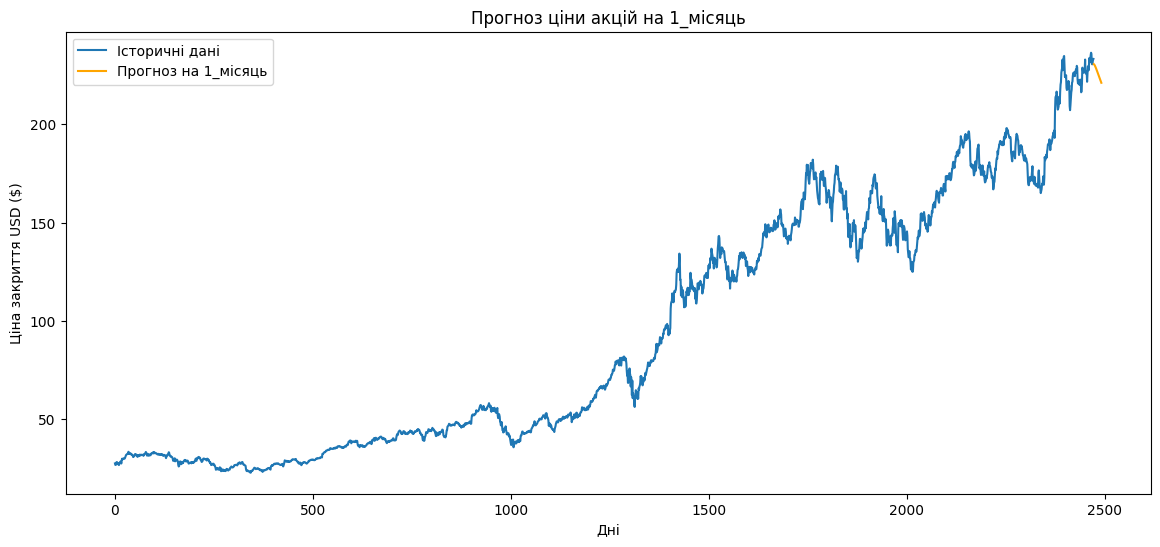

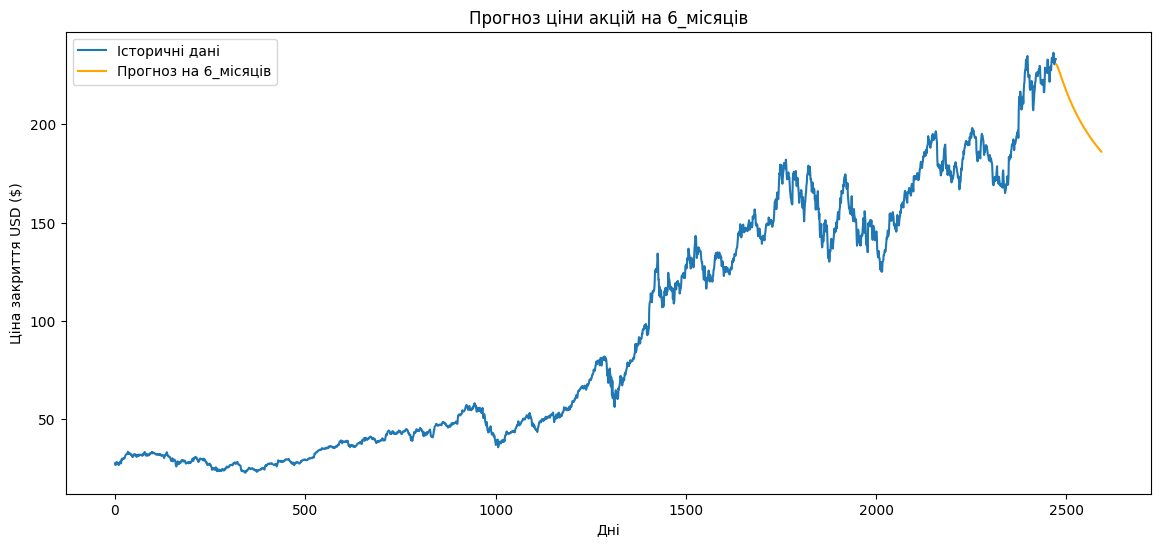

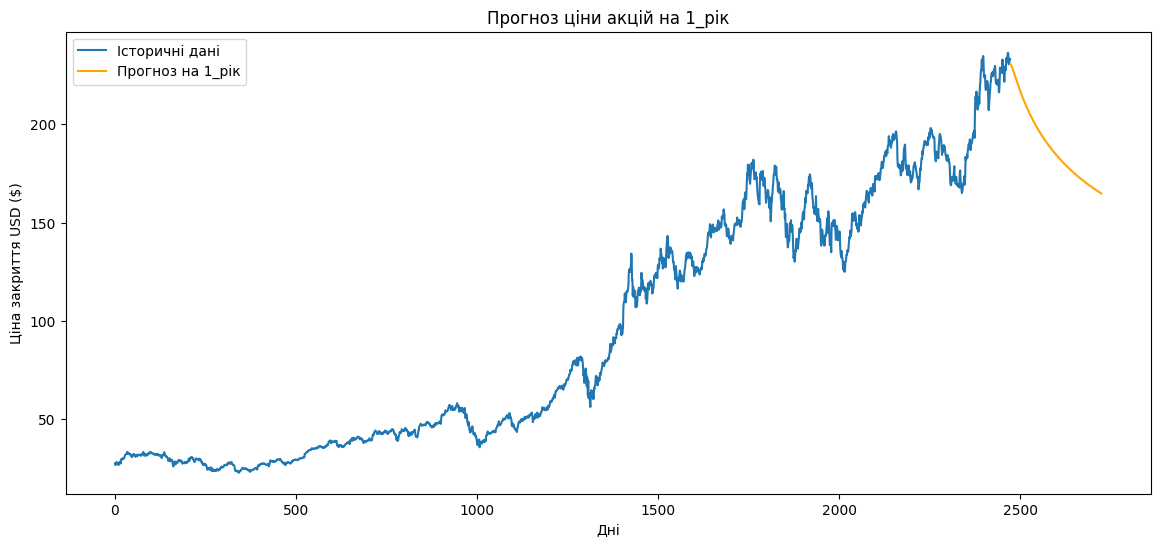

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Налаштовуємо періоди для прогнозування в торгових днях
forecast_days = {
    "1_місяць": 20,
    "6_місяців": 120,
    "1_рік": 252
}

# Функція для прогнозування на заданий період
def multi_step_forecast(model, input_data, forecast_length, scaler):
    predictions = []
    input_sequence = input_data[-window_size:]  # Використовуємо останні точки даних для початкового вікна

    for _ in range(forecast_length):
        # Прогнозуємо наступний крок
        predicted = model.predict(np.reshape(input_sequence, (1, window_size, 1)))

        # Зберігаємо результат
        predictions.append(predicted[0, 0])

        # Оновлюємо вхідні дані: додаємо прогноз у вікно, видаляючи найстаріше значення
        input_sequence = np.append(input_sequence[1:], predicted, axis=0)

    # Зворотне масштабування прогнозованих значень
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Генеруємо прогнози на різні періоди
forecasts = {}
for period, days in forecast_days.items():
    forecasts[period] = multi_step_forecast(model, scaled_data, days, scaler)

# Створимо окремі графіки для кожного періоду
for period, prediction in forecasts.items():
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(data)), data['Close'], label='Історичні дані')
    plt.plot(range(len(data), len(data) + len(prediction)), prediction, label=f'Прогноз на {period}', color='orange')

    plt.title(f'Прогноз ціни акцій на {period}')
    plt.xlabel('Дні')
    plt.ylabel('Ціна закриття USD ($)')
    plt.legend()
    plt.show()


Available Dates: DatetimeIndex(['2015-01-02 00:00:00+00:00', '2015-01-05 00:00:00+00:00',
               '2015-01-06 00:00:00+00:00', '2015-01-07 00:00:00+00:00',
               '2015-01-08 00:00:00+00:00', '2015-01-09 00:00:00+00:00',
               '2015-01-12 00:00:00+00:00', '2015-01-13 00:00:00+00:00',
               '2015-01-14 00:00:00+00:00', '2015-01-15 00:00:00+00:00',
               ...
               '2024-10-16 00:00:00+00:00', '2024-10-17 00:00:00+00:00',
               '2024-10-18 00:00:00+00:00', '2024-10-21 00:00:00+00:00',
               '2024-10-22 00:00:00+00:00', '2024-10-23 00:00:00+00:00',
               '2024-10-24 00:00:00+00:00', '2024-10-25 00:00:00+00:00',
               '2024-10-28 00:00:00+00:00', '2024-10-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2473, freq=None)


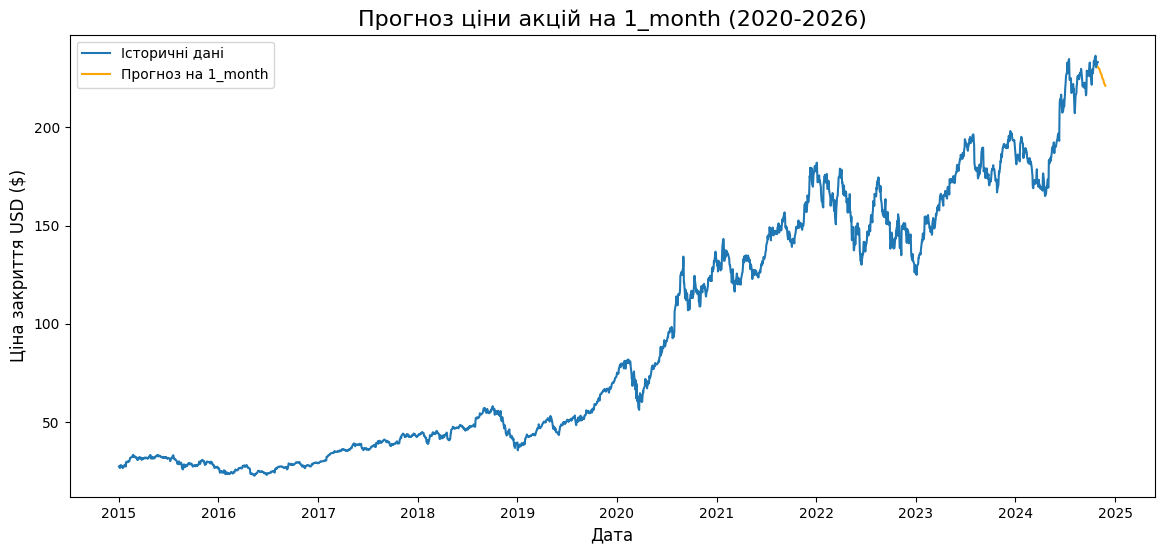

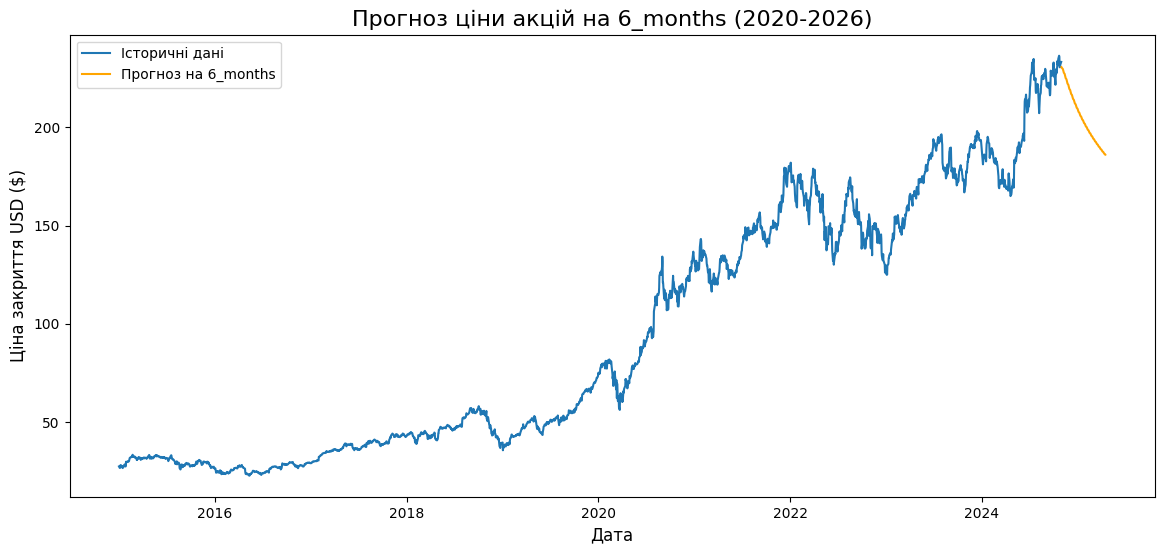

In [ ]:
# Налаштуємо дати для обрізаного виду
start_date = '2020-01-01'
end_date = '2024-10-29'

# Функція для перетворення дати на індекси
def get_date_index(data, start_date, end_date):
    available_dates = data.index
    print("Available Dates:", available_dates)

    start_mask = data.index >= start_date
    end_mask = data.index <= end_date

    if not any(start_mask):
        print(f"Start date {start_date} not found in data.")
        return None, None
    if not any(end_mask):
        print(f"End date {end_date} not found in data.")
        return None, None

    start_index = available_dates[start_mask].get_loc(available_dates[start_mask][0])
    end_index = available_dates[end_mask].get_loc(available_dates[end_mask][-1]) + 1  # включити останній індекс
    return start_index, end_index

# Отримуємо індекси для обрізаного виду
start_index, end_index = get_date_index(data, start_date, end_date)

# Створюємо окремі графіки для кожного періоду з обрізаним видом
for period, prediction in forecasts.items():
    plt.figure(figsize=(14, 6))

    # Обрізаємо дані
    plt.plot(data.index[start_index:end_index], data['Close'].values[start_index:end_index], label='Історичні дані')

    # Показуємо прогнози після 2026 року
    forecast_index = pd.date_range(start=data.index[end_index - 1] + pd.Timedelta(days=1),
                                     periods=len(prediction), freq='B')  # Б'юзнес дні
    plt.plot(forecast_index, prediction, label=f'Прогноз на {period}', color='orange')

    plt.title(f'Прогноз ціни акцій на {period} (2020-2026)', fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Ціна закриття USD ($)', fontsize=12)
    plt.legend()
    plt.show()

